In [1]:
# import required packages

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold, StratifiedKFold,GroupKFold
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsRegressor,KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import mean_squared_error,r2_score,roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gc
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

In [2]:
# read train and test data

train = pd.read_csv("/kaggle/input/dataset/train_Df64byy.csv")
test = pd.read_csv("/kaggle/input/dataset/test_YCcRUnU.csv")

In [3]:
# Check how train data looks...
train.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3,1.0,16,10404.0,0


In [4]:
# As most of the features are categorical, check if test data has all categorical values same as train data.
# If any column has new values then we should be careful using that feature in training directly..

count=0
for col in train.columns:
    if col not in ['ID','Reco_Policy_Premium','Response']:
        for val in test[col].unique():
            if val not in train[col].unique():
                print(col,val)
                count+=1

Region_Code 5232
Region_Code 5670
Region_Code 5764
Region_Code 5528
Region_Code 5207
Region_Code 4802
Region_Code 5339
Region_Code 5463
Region_Code 5716
Region_Code 5544
Region_Code 5788
Region_Code 5915
Region_Code 5917
Region_Code 5442
Region_Code 5920
Region_Code 4699
Region_Code 5404
Region_Code 5453
Region_Code 5926
Region_Code 5497
Region_Code 5573
Region_Code 5711
Region_Code 5018
Region_Code 5728
Region_Code 6117
Region_Code 5822
Region_Code 5727
Region_Code 5515
Region_Code 6046
Region_Code 6126
Region_Code 5642
Region_Code 6047
Region_Code 5773
Region_Code 5841
Region_Code 6072
Region_Code 5851
Region_Code 4811
Region_Code 6056
Region_Code 5211
Region_Code 4863
Region_Code 6068
Region_Code 5141
Region_Code 5684
Region_Code 6065
Region_Code 5595
Region_Code 5465
Region_Code 6184
Region_Code 5414
Region_Code 5867
Region_Code 5730
Region_Code 5695
Region_Code 5948
Region_Code 5872
Region_Code 6180
Region_Code 6040
Region_Code 6039
Region_Code 5702
Region_Code 5747
Region_Code 60

In [5]:
train['Region_Code'].nunique(),test['Region_Code'].nunique(),count

(5316, 4694, 239)

It turns out Region code is the feature which has differet values in train and test...Total 239 values out of 5316 values in train are different...

We will not use this feature directly but will create features using it.

In [6]:
# Let's check if data is uniformly distributed between train and test. Also,if there are any outliers or not.
train.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
count,50882.000000,50882.000000,50882.000000,50882.000000,30631.000000,50882.000000,50882.000000,50882.000000
mean,25441.500000,1732.788707,44.856275,42.738866,2.439228,15.115188,14183.950069,0.239947
std,14688.512535,1424.081652,17.310271,17.319375,1.025923,6.340663,6590.074873,0.427055
min,1.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2280.000000,0.000000
25%,12721.250000,523.000000,28.000000,27.000000,1.000000,12.000000,9248.000000,0.000000
50%,25441.500000,1391.000000,44.000000,40.000000,3.000000,17.000000,13178.000000,0.000000
75%,38161.750000,2667.000000,59.000000,57.000000,3.000000,20.000000,18096.000000,0.000000
max,50882.000000,6194.000000,75.000000,75.000000,4.000000,22.000000,43350.400000,1.000000


In [7]:
test.describe()

,ID,Region_Code,Upper_Age,Lower_Age,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
count,21805.000000,21805.000000,21805.000000,21805.000000,13202.000000,21805.000000,21805.000000
mean,61785.000000,1748.737491,44.877734,42.748085,2.440085,15.138363,14220.306581
std,6294.705646,1438.358949,17.254898,17.269112,1.037627,6.302805,6497.996164
min,50883.000000,1.000000,18.000000,16.000000,1.000000,1.000000,2152.000000
25%,56334.000000,535.000000,28.000000,27.000000,1.000000,12.000000,9285.000000
50%,61785.000000,1392.000000,44.000000,41.000000,3.000000,17.000000,13244.000000
75%,67236.000000,2712.000000,59.000000,57.000000,3.000000,20.000000,18201.600000
max,72687.000000,6185.000000,75.000000,75.000000,4.000000,22.000000,43776.000000


<AxesSubplot:>

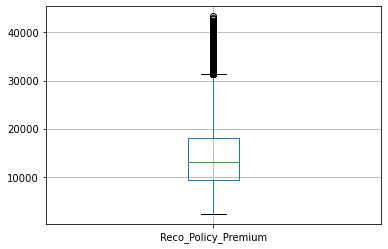

In [8]:
train.boxplot(column=['Reco_Policy_Premium'])

<AxesSubplot:>

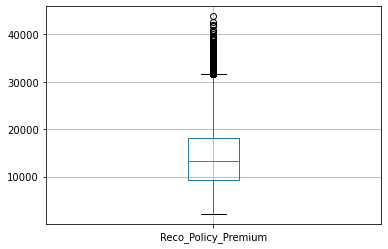

In [9]:
test.boxplot(column=['Reco_Policy_Premium'])

All the numerical features has mean and std almost similar so that is uniformly distributes. It's good :)
Also, we can not see any outlier values(min and max values looks reasonable) in the data so no need to do any outlier handling.

Boxplot suggests some values as outlier but the behavior is same in train and test so let's not do anything. Tree based models will take care of it :)

In [10]:
# join both train and test data for preprocessing..
train['train'] = 1
test['train'] = 0

df = pd.concat([train,test],axis=0).reset_index(drop=True)

# **Let's do some Preprocessing**

In [11]:
# check what is the data type of each feature..
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72687 entries, 0 to 72686
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       72687 non-null  int64  
 1   City_Code                72687 non-null  object 
 2   Region_Code              72687 non-null  int64  
 3   Accomodation_Type        72687 non-null  object 
 4   Reco_Insurance_Type      72687 non-null  object 
 5   Upper_Age                72687 non-null  int64  
 6   Lower_Age                72687 non-null  int64  
 7   Is_Spouse                72687 non-null  object 
 8   Health Indicator         55969 non-null  object 
 9   Holding_Policy_Duration  43833 non-null  object 
 10  Holding_Policy_Type      43833 non-null  float64
 11  Reco_Policy_Cat          72687 non-null  int64  
 12  Reco_Policy_Premium      72687 non-null  float64
 13  Response                 50882 non-null  float64
 14  train                 

In [12]:
# Holding_Policy_Duration feature is ordinal but because of one value it has become categorical. So let's change it...
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].replace({'14+':'15'})

# It has some null values so let's fill null values with -1 so keep its ordinality..
df['Holding_Policy_Duration'].fillna(-1,inplace=True)

# Convert it into float so that we need not to do any ordinal encoding...
df['Holding_Policy_Duration'] = df['Holding_Policy_Duration'].astype(float)

In [13]:
df['Holding_Policy_Duration'].unique()

array([15., -1.,  1.,  3.,  5.,  9., 14.,  7.,  2., 11., 10.,  8.,  6.,
        4., 13., 12.])

Let's check if data has any other null values..

In [14]:
df.isnull().sum()

ID                             0
City_Code                      0
Region_Code                    0
Accomodation_Type              0
Reco_Insurance_Type            0
Upper_Age                      0
Lower_Age                      0
Is_Spouse                      0
Health Indicator           16718
Holding_Policy_Duration        0
Holding_Policy_Type        28854
Reco_Policy_Cat                0
Reco_Policy_Premium            0
Response                   21805
train                          0
dtype: int64

There are two features which has null values but we can not say it's missing values because these features having null values is obvious, it means we don't have we know health indicator of some customers and there are some customers who don't
hold existing policy. Both the cases are valid business case we need not to do explicit missing value treatment. We can just fill it with some other value to let model know it's pattern(missing value has lot of info here) or we can keep it
as null as some models can handle them very well like LGBM..

Let's do label encoding for categorical variables but make sure it does not create random category for null values so I will exclude null records and will keep as it is..

Note - Null values should be clearly recognized by model so always fill it with some extreme values like -999. We will mainly use tree based models so there extreme values will not create any issue.

In [15]:
# save the list of categorical coumns for future use..
categorical_columns = [col for col in df.columns if df[col].dtype == 'object']

In [16]:
def label_encoder_exclude_nan(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    for feat in categorical_columns:
        le = LabelEncoder()
        fit_by = pd.Series([i for i in df[feat].unique() if type(i) == str])
        le.fit(fit_by)
        ### Set transformed col leaving np.NaN as they are
        df[feat] = df[feat].map(lambda x: le.transform([x])[0] if type(x) == str else x)
    print('Label encoding complete.')
    return df

In [17]:
df = label_encoder_exclude_nan(df)

Label encoding complete.


In [18]:
# Let's normalize the Premium feature and see if it helps model to learn better. Results show it's helping the model..
df['Reco_Policy_Premium'] = np.log1p(df['Reco_Policy_Premium'])

# **Let's do Feature Engineering**

In [19]:
# Let's do some binning of continuous columns..

df['Upper_Age_bin'] =  pd.qcut(df['Upper_Age'], 5).astype('object').astype(str)
df['Lower_Age_bin'] =  pd.qcut(df['Lower_Age'], 5).astype('object').astype(str)

In [20]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,train,Upper_Age_bin,Lower_Age_bin
0,1,22,3213,1,0,36,36,0,0.0,15.0,3.0,22,9.361257,0.0,1,"(26.0, 37.0]","(34.0, 47.0]"
1,2,31,1117,0,1,75,22,0,1.0,-1.0,NaN,22,10.325843,0.0,1,"(63.0, 75.0]","(15.999, 25.0]"
2,3,31,3732,0,0,32,32,0,NaN,1.0,1.0,19,8.916104,1.0,1,"(26.0, 37.0]","(25.0, 34.0]"
3,4,16,4378,0,1,52,48,0,0.0,15.0,3.0,19,9.785886,0.0,1,"(50.0, 63.0]","(47.0, 61.0]"
4,5,34,2190,1,0,44,44,0,1.0,3.0,1.0,16,9.250042,0.0,1,"(37.0, 50.0]","(34.0, 47.0]"


In [21]:
df = label_encoder_exclude_nan(df)

Label encoding complete.


In [22]:
# Create feature using count of each value, it will help to find most popular and least popular category in each feature

def encode_FE(df,col):
    cv = df[col].value_counts()
    nm = str(col)+'_FE'
    df[nm] = df[col].map(cv)

feats = [f for f in df.columns if f not in ['Response','train','ID']]
for col in feats:
    encode_FE(df,col)

In [23]:
# take age difference to help the model know for joint insurance type, how big is age difference..
df['age_diff'] =  (df['Upper_Age'] - df['Lower_Age'])

In [24]:
# Take premium price to lower age and age diff ratio. Hypothesis is as age increases the premium price increases.
# It will help the model to know if any customer is being charged heavily for same age. If yes, there is less chance he will buy
df['prem_vs_lowerage'] = df['Reco_Policy_Premium']/df['Lower_Age']
df['prem_vs_agediff'] = df['Reco_Policy_Premium']/df['age_diff']

In [25]:
# Find top 10 largest values and take it's sum.
def top_10_sum(x):
    return x.nlargest(10).sum()

# Find bottom 10 smallest values and take it's sum.
def bottom_10_sum(x):
    return x.nsmallest(10).sum()

# function to calculate mode..
def calc_mode(x):
    return pd.Series.mode(x)[0]

In [26]:
"""
We will do feature engineering by creating some aggregation features for different feature combinations based on business
understanding..

Let me explain few..
1. For each city and Policy category which is being recommended, find out what is the min,mean,max,std and skew in price.
2. For each Region_Code and Policy category which is being recommended, find out what is the min,mean,max,std and skew 
in price. Also, what is the top 10 or bottom 10 prices sum to give the info - which region is costlier or cheaper
for each policy. It really helped model, see the top feature list at last :)

I have tried different other combinations and whichever helped the model based on accuracy on validation set is kept below..
"""
AGGREGATION_RECIPIES = [(['City_Code','Reco_Policy_Cat'], 
                         [
                            ('Reco_Policy_Premium', 'min'),
                            ('Reco_Policy_Premium', 'mean'),
                             ('Reco_Policy_Premium', 'max'),
                             ('Reco_Policy_Premium', 'std'),
                             ('Reco_Policy_Premium', 'skew')
                        ]
                        ),
                        (['Region_Code','Reco_Policy_Cat'], 
                         [
                            ('Reco_Policy_Premium', 'min'),
                            ('Reco_Policy_Premium', 'mean'),
                             ('Reco_Policy_Premium', 'max'),
                             ('Reco_Policy_Premium', 'std'),
                             ('Reco_Policy_Premium', 'skew'),
                             ('Reco_Policy_Premium', top_10_sum),
                             ('Reco_Policy_Premium', bottom_10_sum)
                         ]
                        ),
                        (['Region_Code'], 
                         [
                            ('Reco_Policy_Cat', 'count'),
                            ('Reco_Policy_Cat', 'min'),
                             ('Reco_Policy_Cat', 'mean'),
                             ('Reco_Policy_Cat', 'max'),
                             ('Reco_Policy_Cat', 'std'),
                             ('Reco_Policy_Cat', 'skew'),
                             ('Reco_Policy_Cat', calc_mode)
                         ]
                        ),
                     (['Accomodation_Type','Reco_Policy_Cat'], 
                         [
                            ('Reco_Policy_Premium', 'min'),
                            ('Reco_Policy_Premium', 'mean'),
                             ('Reco_Policy_Premium', 'max'),
                             ('Reco_Policy_Premium', 'std'),
                         ]
                        ),
                        (['Holding_Policy_Type','Reco_Policy_Cat'], 
                         [
                            ('Reco_Policy_Premium', 'min'),
                            ('Reco_Policy_Premium', 'mean'),
                             ('Reco_Policy_Premium', 'max'),
                             ('Reco_Policy_Premium', 'std'),
                         ]
                        ),
                        (['Reco_Policy_Cat'], 
                         [
                            ('Reco_Policy_Premium', 'min'),
                            ('Reco_Policy_Premium', 'mean'),
                             ('Reco_Policy_Premium', 'max'),
                             ('Reco_Policy_Premium', 'std'),
                             ('Reco_Policy_Premium', 'skew')
                         ]
                        ),
]

groupby_aggregate_names = []
for groupby_cols, specs in tqdm(AGGREGATION_RECIPIES):
    group_object = df.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_aggregate_name = '{}_{}_{}'.format('_'.join(groupby_cols), agg, select)
        df = df.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_aggregate_name})
                              [groupby_cols + [groupby_aggregate_name]],
                              on=groupby_cols,
                              how='left')
        groupby_aggregate_names.append(groupby_aggregate_name)

100%|██████████| 6/6 [00:28<00:00,  4.67s/it]


In [27]:
# Fillna with some large negative value so that model identifies it easily..
df.fillna(-999,inplace=True)

# Similarly, replace inf values with some large positive values...
df.replace({np.inf:99999,-np.inf:99999},inplace=True)

In [28]:
df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,train,Upper_Age_bin,Lower_Age_bin,City_Code_FE,Region_Code_FE,Accomodation_Type_FE,Reco_Insurance_Type_FE,Upper_Age_FE,Lower_Age_FE,Is_Spouse_FE,Health Indicator_FE,Holding_Policy_Duration_FE,Holding_Policy_Type_FE,Reco_Policy_Cat_FE,Reco_Policy_Premium_FE,Upper_Age_bin_FE,Lower_Age_bin_FE,age_diff,prem_vs_lowerage,prem_vs_agediff,City_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,City_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_min_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_mean_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_max_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_std_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_skew_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_<function top_10_sum at 0x7fc99b94ba70>_Reco_Policy_Premium,Region_Code_Reco_Policy_Cat_<function bottom_10_sum at 0x7fc99b94b8c0>_Reco_Policy_Premium,Region_Code_count_Reco_Policy_Cat,Region_Code_min_Reco_Policy_Cat,Region_Code_mean_Reco_Policy_Cat,Region_Code_max_Reco_Policy_Cat,Region_Code_std_Reco_Policy_Cat,Region_Code_skew_Reco_Policy_Cat,Region_Code_<function calc_mode at 0x7fc99b94bcb0>_Reco_Policy_Cat,Accomodation_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Accomodation_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_min_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_mean_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_max_Reco_Policy_Premium,Holding_Policy_Type_Reco_Policy_Cat_std_Reco_Policy_Premium,Reco_Policy_Cat_min_Reco_Policy_Premium,Reco_Policy_Cat_mean_Reco_Policy_Premium,Reco_Policy_Cat_max_Reco_Policy_Premium,Reco_Policy_Cat_std_Reco_Policy_Premium,Reco_Policy_Cat_skew_Reco_Policy_Premium
0,1,22,3213,1,0,36,36,0,0.0,15.0,3.0,22,9.361257,0.0,1,1,2,6954,10,32646,57877,1066,1066,60687,18624.0,6227,18851.0,9459,36,14430,13898,0,0.260035,99999.000000,7.905810,9.441321,10.464188,0.483515,-0.296917,9.361257,9.361257,9.361257,-999.000000,-999.000000,9.361257,9.361257,10,16,19.100000,22,2.330951,-0.215821,21,7.809947,9.241130,10.651525,0.472523,8.178919,9.575787,10.651525,0.429273,7.809947,9.472639,10.652963,0.495680,-0.333172
1,2,31,1117,0,1,75,22,0,1.0,-1.0,-999.0,22,10.325843,0.0,1,4,0,1963,21,40041,14810,4231,2442,60687,14848.0,28854,-999.0,9459,2,13757,15808,53,0.469356,0.194827,8.312626,9.419979,10.581506,0.508936,-0.220916,8.312626,9.625685,10.581506,0.604669,-0.748327,99.813933,93.012341,21,14,21.238095,22,1.997618,-3.107835,22,7.921898,9.651059,10.652963,0.435740,-999.000000,-999.000000,-999.000000,-999.000000,7.809947,9.472639,10.652963,0.495680,-0.333172
2,3,31,3732,0,0,32,32,0,-999.0,1.0,1.0,19,8.916104,1.0,1,1,1,1963,8,40041,57877,1272,1355,60687,-999.0,6390,11747.0,5319,7,14430,14144,0,0.278628,99999.000000,8.391857,9.493275,10.401106,0.430577,-0.285322,8.916104,9.015352,9.114600,0.140358,-999.000000,18.030704,18.030704,8,1,5.500000,19,8.332381,1.440165,1,7.993282,9.645024,10.670057,0.411237,8.248791,9.551039,10.670057,0.412742,7.872836,9.493225,10.670057,0.468723,-0.355766
3,4,16,4378,0,1,52,48,0,0.0,15.0,3.0,19,9.785886,0.0,1,3,3,823,5,40041,14810,1229,1120,60687,18624.0,6227,18851.0,5319,32,14857,15075,4,0.203873,2.446471,8.338784,9.557989,10.670057,0.457676,-0.249435,9.785886,9.785886,9.785886,-999.000000,-999.000000,9.785886,9.785886,5,1,7.800000,19,8.526429,0.721601,2,7.993282,9.645024,10.670057,0.411237,8.276649,9.637014,10.532283,0.441302,7.872836,9.493225,10.670057,0.468723,-0.355766
4,5,34,2190,1,0,44,44,0,1.0,3.0,1.0,16,9.250042,0.0,1,2,2,2579,14,32646,57877,1139,1051,6068

In [29]:
categorical_columns

['City_Code',
 'Accomodation_Type',
 'Reco_Insurance_Type',
 'Is_Spouse',
 'Health Indicator']

In [30]:
df.shape

(72687, 66)

In [31]:
# list of features which model will treat as categorical...
cat_features = ['City_Code','Reco_Policy_Cat','Lower_Age_bin','Upper_Age_bin']

In [32]:
"""
function to train LGBM model with stratified Kfold.

Finally, I have used LightGBM model for training the data. I have used stratified Kfold(10) as cross validation technique.

While training the model, I have excluded below features –
•ID - as told in competition rule.
•Region_Code - as the values in test are different from train. I have done FE using it, so I have all info from this feature that is needed by model.
•Upper_Age - as I have already included age_diff feature so it will be redundant info.

I have also done parameter tuning for model and finally used parameters which worked well with early stopping so that model
does not overfit. Also, for feature selection, I have used reg_alpha parameter and to handle overfitting, used reg_lambda,
colsample_bytree, subsample parameters.

"""

def train_lgbm(df,seed,cat_features):
    X = df[df['train']==1]
    y = df[df['train']==1]['Response']
    test_data = df[df['train']==0]
    num_split = 10
    folds = StratifiedKFold(n_splits=num_split)
    excluded_features = ['Response','train','ID','Region_Code','Upper_Age']
    train_features = [_f for _f in X.columns if _f not in excluded_features]
    importances = pd.DataFrame()
    oof_reg_preds = np.zeros(X.shape[0])
    test_preds = np.zeros(test_data.shape[0])
    for fold_, (trn_, val_) in enumerate(folds.split(X, y)):
        print("Fold:",fold_)
        trn_x, trn_y = X[train_features].iloc[trn_], y.iloc[trn_]
        val_x, val_y = X[train_features].iloc[val_], y.iloc[val_]
        clf1 = LGBMClassifier(
            n_jobs=-1,
            learning_rate=0.0094,
            n_estimators=10000,
            colsample_bytree=0.94,
            subsample = 0.75,
            subsample_freq = 1,
            reg_alpha= 1.0,
            reg_lambda = 5.0,
            random_state=seed
        )
        clf1.fit(
            trn_x,trn_y ,
            eval_set=[(val_x, val_y)],
            early_stopping_rounds=100,
            verbose=False,
            eval_metric='auc',
            categorical_feature = cat_features
        )
        
        # Extra boosting.
        clf = LGBMClassifier(
            n_jobs=-1,
            learning_rate=0.00094,
            n_estimators=10000,
            colsample_bytree=0.94,
            subsample = 0.75,
            subsample_freq = 1,
            reg_alpha= 1.0,
            reg_lambda = 5.0,
            random_state=seed
        )
        clf.fit(
            trn_x,trn_y ,
            eval_set=[(val_x, val_y)],
            early_stopping_rounds=300,
            verbose=False,
            eval_metric='auc',
            categorical_feature = cat_features,
            init_model = clf1
        )
        
        imp_df = pd.DataFrame()
        imp_df['feature'] = train_features
        imp_df['importance'] = clf.booster_.feature_importance(importance_type='gain')

        imp_df['fold'] = fold_ + 1
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

        oof_reg_preds[val_] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
        _preds = clf.predict_proba(test_data[train_features], num_iteration=clf.best_iteration_)[:, 1]
        test_preds += _preds
        print("fold"+str(fold_)+" auc",roc_auc_score(val_y, oof_reg_preds[val_]))
        del  trn_x, trn_y, val_x, val_y,trn_, val_
        gc.collect()

    test_preds = test_preds/num_split
    print(roc_auc_score(y, oof_reg_preds))
    
    return test_preds,importances,oof_reg_preds,clf,train_features

In [33]:
# train the model by passing data, random seed as 42 and categorical feature list...
lgbm_preds,feat_imp_lgbm,oof_lgbm,lgbm_model,feats = train_lgbm(df,42,cat_features)

Fold: 0
fold0 auc 0.8144198772430417
Fold: 1
fold1 auc 0.8092625858913347
Fold: 2
fold2 auc 0.8129570922406633
Fold: 3
fold3 auc 0.8215116167016865
Fold: 4
fold4 auc 0.8124261506728534
Fold: 5
fold5 auc 0.8153410480796053
Fold: 6
fold6 auc 0.82224505343202
Fold: 7
fold7 auc 0.8143456242758027
Fold: 8
fold8 auc 0.8175142488563746
Fold: 9
fold9 auc 0.8075794957098293
0.8147395378583516


In [34]:
# train the model by passing data, random seed as 11 and categorical feature list...
lgbm_preds1,feat_imp_lgbm1,oof_lgbm1,lgbm_model1,feats = train_lgbm(df,11,cat_features)

Fold: 0
fold0 auc 0.814438933621974
Fold: 1
fold1 auc 0.8090154881778459
Fold: 2
fold2 auc 0.8138517809008764
Fold: 3
fold3 auc 0.8205551626808415
Fold: 4
fold4 auc 0.8117727714314216
Fold: 5
fold5 auc 0.8165539825741532
Fold: 6
fold6 auc 0.8224769659990763
Fold: 7
fold7 auc 0.8139775292606946
Fold: 8
fold8 auc 0.8175017531107523
Fold: 9
fold9 auc 0.8070627225010467
0.814660848207216


In [35]:
# Function to display feature importance...
def display_importances(feature_importance_df_,model):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:30].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(12, 8))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title(model+" Features (avg over folds)")
    plt.tight_layout()
    plt.savefig(model +"_importances-01.png")

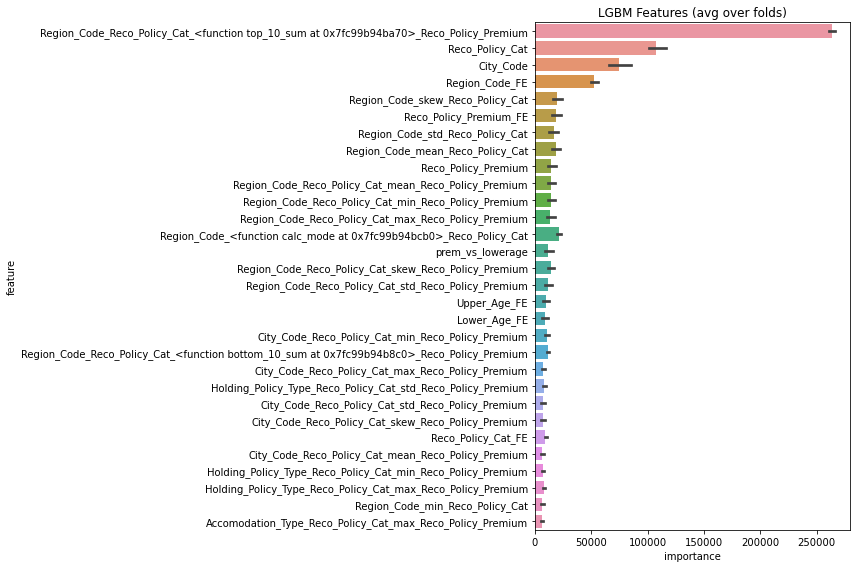

In [36]:
# Feature importance based on gain...

display_importances(feat_imp_lgbm,"LGBM")

In [37]:
# check which ensemble combination gives high score
oof_ensemble = oof_lgbm*0.55 + oof_lgbm1*0.45
roc_auc_score(df[df['train']==1]['Response'],oof_ensemble)

0.8148332542380982

In [38]:
# doing ensemble for final predictions
final_preds = lgbm_preds*0.55 + lgbm_preds1*0.45

In [39]:
# Final submission for test data...

submission_df = pd.DataFrame()
submission_df['ID'] = df[df['train']==0]['ID']
submission_df['Response'] = final_preds

In [40]:
submission_df.head()

,ID,Response
50882,50883,0.077193
50883,50884,0.088754
50884,50885,0.437538
50885,50886,0.097391
50886,50887,0.028776


In [41]:
submission_df.to_csv('submission.csv',index=False)